In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
%cd /content/drive/My Drive/Colab Notebooks/Transformers

/content/drive/My Drive/Colab Notebooks/Transformers


In [ ]:
import torch
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.distributions as dist
import random, tqdm, sys, math, gzip, os
import numpy as np
from utils.util import d, save_checkpoint, load_checkpoint


import matplotlib.pyplot as plt
from transformers import GTransformer
CUDA_LAUNCH_BLOCKING=1

In [ ]:
def sample(lnprobs, temperature=1.0):
    """
    Sample an element from a categorical distribution
    :param lnprobs: Outcome log-probabilities
    :param temperature: Sampling temperature. 1.0 follows the given distribution,
        0.0 returns the maximum probability element.
    :return: The index of the sampled element.
    """

    if temperature == 0.0:
        return lnprobs.argmax()

    p = F.softmax(lnprobs / temperature, dim=0)
    cd = dist.Categorical(p)

    return cd.sample()

In [ ]:
def trainF(model, data_train, data_test, num_batches, refcontext, test_every, test_subset, test_batchsize, criterion, save_name):

    gradient_clipping = 1.0
    best_bits_per_byte = float("Inf")
    total_bits = []


    # training loop
    # - note: we don't loop over the data, instead we sample a batch of random subsequences each time.
    for i in tqdm.trange(num_batches):
        # sample a batch of random subsequences
        starts = torch.randint(size=(batch_size, ), low=0, high=data_train.size(0) - refcontext - 1)
        seqs_source = [data_train[start  :start+refcontext] for start in starts]
        seqs_target = [data_train[start+1:start+refcontext+1] for start in starts]
        source = torch.cat([s[None, :] for s in seqs_source ], dim=0).to(torch.long)
        target = torch.cat([s[None, :] for s in seqs_target ], dim=0).to(torch.long)
        # - target is the same sequence as source, except one character ahead

        if torch.cuda.is_available():
            source, target = source.cuda(), target.cuda()
        source, target = Variable(source), Variable(target)

        output = model(source)

        loss = criterion(output.transpose(2, 1), target)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()       

        # clip gradients
        # - If the total gradient vector has a length > 1, we clip it back down to 1.
        if gradient_clipping > 0.0:
            nn.utils.clip_grad_norm_(model.parameters(), gradient_clipping)

        optimizer.step()
        scheduler.step()

        # - validate every {test_every} steps. First we compute the
        #   compression on the validation (or a subset)
        #   then we generate some random text to monitor progress
        if i != 0 and (i % test_every == 0 or i == num_batches - 1):

            upto = data_test.size(0) if i == num_batches - 1 else test_subset
            data_sub = data_test[:upto]

            with torch.no_grad():
                bits, tot = 0.0, 0
                batch = [] # buffer, every time it fills up, we run it through the model

                for current in range(data_sub.size(0)):

                    fr = max(0, current - refcontext)
                    to = current + 1

                    context = data_sub[fr:to].to(torch.long)
                    
                    if context.size(0) < refcontext + 1:
                        pad = torch.zeros(size=(refcontext + 1 - context.size(0),), dtype=torch.long)
                        context = torch.cat([pad, context], dim=0)

                        assert context.size(0) == refcontext + 1

                    if torch.cuda.is_available():
                        context = context.cuda()

                    batch.append(context[None, :])

                    if len(batch) == test_batchsize or current == data_sub.size(0) - 1:

                        # batch is full, run it through the model
                        b = len(batch)

                        all = torch.cat(batch, dim=0)
                        source = all[:, :-1] # input
                        target = all[:, -1]  # target values

                        output = model(source)

                        lnprobs = output[torch.arange(b, device=d()), -1, target]
                        log2probs = lnprobs * LOG2E # convert from nats to bits

                        bits += - log2probs.sum()
                        batch = [] # empty buffer
                        

                bits_per_byte = bits / data_sub.size(0)

                total_bits.append(bits_per_byte)

                # print validation performance. 1 bit per byte is (currently) state of the art.
                print(f'epoch{i}: {bits_per_byte:.4} bits per byte')

                if bits_per_byte < best_bits_per_byte:
                  best_bits_per_byte = bits_per_byte
                  save_checkpoint(save_name, model, optimizer, best_bits_per_byte)


                # generate some random text
                GENSIZE = 600
                TEMP = 0.5
                seedfr = random.randint(0, data_test.size(0) - refcontext)
                input = data_test[seedfr:seedfr + refcontext].to(torch.long)

                if torch.cuda.is_available():
                    input = input.cuda()

                input = Variable(input)

                print('[', end='', flush=True)
                for c in input:
                    print(str(chr(c)), end='', flush=True)
                print(']', end='', flush=True)

                for _ in range(GENSIZE):
                    output = model(input[None, :])
                    c = sample(output[0, -1, :], TEMP)
                    print(str(chr(max(32, c))), end='', flush=True)

                    input = torch.cat([input[1:], c[None]], dim=0)

                print()


    print("Finished Training")
    return total_bits

In [ ]:
def eval(model, test_loader):

    with torch.no_grad():
        bits = 0.0
        refcontext = 256
        # batch is full, run it through the model
        for i in tqdm.trange(test_loader.size(0)):
          seedfr = random.randint(0, test_loader.size(0) - refcontext)
          input = test_loader[seedfr:seedfr + refcontext].to(torch.long)

          context = input
          b = len(context[None, :])

          if context.size(0) < refcontext + 1:
              pad = torch.zeros(size=(refcontext + 1 - context.size(0),), dtype=torch.long)
              context = torch.cat([pad, context], dim=0)

          if torch.cuda.is_available():
            context = context.cuda()

          source = context[None, :-1] # input
          target = context[-1]  # target values

          output = model(source)

          lnprobs = output[torch.arange(b, device=d()), -1, target]
          log2probs = lnprobs * LOG2E # convert from nats to bits

          bits += - log2probs.sum()

        bits_per_byte = bits / len(test_loader)

        # print test performance. 1 bit per byte is (currently) state of the art.
        print('bits per byte: ', bits_per_byte)

        # generate some random text
        GENSIZE = 600
        TEMP = 0.5
        seedfr = random.randint(0, test_loader.size(0) - refcontext)
        input = test_loader[seedfr:seedfr + refcontext].to(torch.long)

        if torch.cuda.is_available():
            input = input.cuda()

        input = Variable(input)

        print('[', end='', flush=True)
        for c in input:
            print(str(chr(c)), end='', flush=True)
        print(']', end='', flush=True)

        for _ in range(GENSIZE):
            output = model(input[None, :])
            c = sample(output[0, -1, :], TEMP)
            print(str(chr(max(32, c))), end='', flush=True)

            input = torch.cat([input[1:], c[None]], dim=0)

        print()   


In [ ]:
def enwik9(path, n_train=int(90e6), n_valid=int(5e6), n_test=int(5e6)):
    """
    Load the enwik8 dataset from the Hutter challenge.
    Adapted from https://github.com/openai/blocksparse/blob/master/examples/transformer/enwik8.py
    :param path:
    :param n_train:
    :param n_valid:
    :param n_test:
    :return:
    """
    with open(path) as file:
        X = np.fromstring(file.read(n_train + n_valid + n_test), dtype=np.uint8)
        trX, vaX, teX = np.split(X, [n_train, n_train + n_valid])
        return torch.from_numpy(trX), torch.from_numpy(vaX), torch.from_numpy(teX)

In [ ]:
# NB, the enwik8 data contains tokens from 9 to 240, but well round up to the nearest
# power of two.
NUM_TOKENS = 256
# Used for converting between nats and bits
LOG2E = math.log2(math.e)

data = 'enwik9'

data_train, data_val, data_test = enwik9(data)

print ('nr of train examples', len(data_train))
print ('nr of valid examples', len(data_val))
print ('nr of test examples', len(data_test))

nr of train examples 90000000
nr of valid examples 5000000
nr of test examples 5379691


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


In [ ]:
embedding_size = 128
num_heads = 8
depth = 12
refcontext = 256
wide = True

batch_size = 32

# create the model
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = GTransformer(emb=embedding_size, heads=num_heads, depth=depth, seq_length=refcontext, num_tokens=NUM_TOKENS, wide=wide)
if torch.cuda.is_available():
    model.cuda()

temp = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The model architecture:\n\n', model)
print(f'\nThe model has {temp:,} trainable parameters')

The model architecture:

 GTransformer(
  (token_embedding): Embedding(256, 128)
  (pos_embedding): Embedding(256, 128)
  (tblocks): Sequential(
    (0): TransformerBlock(
      (attention): SelfAttentionWide(
        (tokeys): Linear(in_features=128, out_features=1024, bias=False)
        (toqueries): Linear(in_features=128, out_features=1024, bias=False)
        (tovalues): Linear(in_features=128, out_features=1024, bias=False)
        (unifyheads): Linear(in_features=1024, out_features=128, bias=True)
      )
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (ff): Sequential(
        (0): Linear(in_features=128, out_features=512, bias=True)
        (1): ReLU()
        (2): Linear(in_features=512, out_features=128, bias=True)
      )
      (do): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (attention): SelfAttentionWide(
        (tokeys): Linear(in_features=128, out_f

In [ ]:
# start training
optimizer = torch.optim.Adam(lr = 0.0001, params=model.parameters())
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda i: min(i / (5000/batch_size), 1.0))
criterion = nn.NLLLoss(reduction='mean')
num_batches = 10000
test_every = 100
test_subset = 10000
test_batchsize = 64
save_path = 'GTransformersNet.pt'
bits_per_byte = trainF(model, data_train, data_val, num_batches, refcontext, test_every, test_subset, test_batchsize, criterion, save_path)

In [ ]:
load_model = GTransformer(emb=embedding_size, heads=num_heads, depth=depth, seq_length=refcontext, num_tokens=NUM_TOKENS, wide=wide).to(device)
load_optimizer = torch.optim.Adam(load_model.parameters(), lr=0.0001)

best_val_loss = load_checkpoint(load_model, save_path, load_optimizer)
print(best_val_loss)

test_subset = 10000

eval(load_model, data_test[:test_subset])

  0%|          | 7/10000 [00:00<02:25, 68.82it/s]

Model loaded from <== GTransformersNet.pt
tensor(1.9722, device='cuda:0')


100%|██████████| 10000/10000 [01:57<00:00, 85.30it/s]

bits per byte:  tensor(1.9145, device='cuda:0')
[enerator-builders. The ''alternator'' syntax allows a series of items to be generated in sequence

 until one fails: &lt;code&gt;1 | &quot;hello&quot; | x &lt; 5&lt;/code&gt; can generate &quot;1&quot;, &quot;hello&quot;, and &quot;5&quot; if x is less than ]input shape---> torch.Size([256]) torch.Size([1, 256])
the &quot;code of the [[can faility]]&quot;, &quot;code&quot; with the [[control]], [[crossone]]&quot; is the tribe of a change also defined to be the [[epitoday of the illustric to not the controlled in the [[Anthropology]] of [[the Canada]] and [[2005]]. The [[anthropology]] set as a [[Terriba]] and [[Anthropology]] by the [[Anthropology]] part of the [[Stari Countile County of the [[Anthropology]] and [[Anthropology]] in [[Anthropology]].  The set of [[Anthropology]] and [[Anthropology]] was an introduced to the [[Anthropology]] of [[Bary University]], [[Facile Starial]], [[Anthropology]], 


NameError: ignored

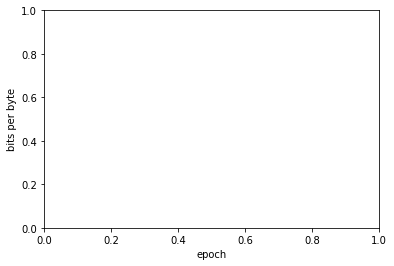

In [ ]:
#plotting of training and validation loss
plt.xlabel('epoch')
plt.ylabel('bits per byte')
plt.plot(bits_per_byte, label='bits_per_byte')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

Prediction

In [ ]:
def predict(model, test_loader):

    context = [ord(c) for c in test_loader]
    context = np.asarray(context)
    context = torch.from_numpy(context)
    
    with torch.no_grad():
        model.eval()
        refcontext = 256
        # generate some random text
        GENSIZE = 600
        TEMP = 0.5

        if context.size(0) < refcontext + 1:
            pad = torch.zeros(size=(refcontext - context.size(0),), dtype=torch.long)
            input = torch.cat([pad, context], dim=0)
        elif context.size(0) > 256:
            input = context[-256:]
        else:
            input = context

        if torch.cuda.is_available():
            input = input.cuda()

        input = Variable(input)

        print (f"Input text considered according to model config....\n")

        print('[', end='', flush=True)
        for c in input:
            print(str(chr(c)), end='', flush=True)
        print(']', end='', flush=True)

        print (f"\nGenerated text....\n")

        for _ in range(GENSIZE):
            output = model(input[None, :]).to(device)
            c = sample(output[0, -1, :], TEMP)
            print(str(chr(max(32, c))), end='', flush=True)

            input = torch.cat([input[1:], c[None]], dim=0)

        print()  

In [ ]:
text = "1228X Human & Rousseau. Because many of his stories were originally published in long-forgotten magazines and journals, there are a number of [[anthology|anthologies]] by different collators each containing a different selection. His original books ha"
# NB, the enwik8 data contains tokens from 9 to 240, but well round up to the nearest
# power of two.
NUM_TOKENS = 256
# Used for converting between nats and bits
LOG2E = math.log2(math.e)

embedding_size = 128
num_heads = 8
depth = 12
refcontext = 256
wide = True

#creating the original network
save_path = 'GTransformersNet.pt' 
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') 
load_model = GTransformer(emb=embedding_size, heads=num_heads, depth=depth, seq_length=refcontext, num_tokens=NUM_TOKENS, wide=wide).to(device)
state_dict = torch.load(save_path)
load_model.load_state_dict(state_dict['model_state_dict'])
load_optimizer = torch.optim.Adam(load_model.parameters(), lr=0.0001)
load_optimizer.load_state_dict(state_dict['optimizer_state_dict'])
val_loss = state_dict['val_loss']
print(f'Bits per byte info of loaded model: ',val_loss)

predict(load_model, text)


Bits per byte info of loaded model:  tensor(1.9722, device='cuda:0')
Input text considered according to model config....

[     1228X Human & Rousseau. Because many of his stories were originally published in long-forgotten magazines and journals, there are a number of [[anthology|anthologies]] by different collators each containing a different selection. His original books ha]
Generated text....

ve been the selection of the contain of the published and his the formal in [[196]] in [[1983]]. The are contained a most of the [[Articital of Ships|Articital (colland)|Articital of Articital Articital Manage]] between the [[Charles of Articital Charles and Sharet]] in the [[Ships of Articital Charles]]. In [[1822]] the [[Charles of Goth Articital Controlland]] in the [[Articital Colland]] and [[Charles Articital Charles of [[Charles Charles]] and [[Charles International Charles and [[Charles Central Charles]]. In the [[International Community]] and [[Charles Charles]] is the [[Charles Colla